In [130]:
!pip install scikit-learn


[notice] A new release of pip available: 22.3.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# 엑셀 파일 불러오기
Kyield_data = pd.read_excel('K3Y10Y.xlsx', header=None)
Krecession_data = pd.read_excel('recession_dummy.xlsx', header=None)
Call_rate = pd.read_excel('CallRate.xlsx', header=None)
Core_cpi = pd.read_excel('KcoreCPI.xlsx', header=None)

# 첫 번째 행에 제목 추가
Kyield_data.columns = ['Date', '3Y', '10Y']
Krecession_data.columns = ['Date', 'Recession']
Call_rate.columns = ['Date', 'Call_Rate']
Core_cpi.columns = ['Date', 'Core_CPI']

# 날짜를 인덱스로 설정
Kyield_data['Date'] = pd.to_datetime(Kyield_data['Date'], errors='coerce')
Kyield_data.set_index('Date', inplace=True)

Call_rate['Date'] = pd.to_datetime(Call_rate['Date'], errors='coerce')
Call_rate.set_index('Date', inplace=True)

Core_cpi['Date'] = pd.to_datetime(Core_cpi['Date'], errors='coerce')
Core_cpi.set_index('Date', inplace=True)

Krecession_data['Date'] = pd.to_datetime(Krecession_data['Date'], errors='coerce')
Krecession_data.set_index('Date', inplace=True)

# 데이터 병합
data = Kyield_data.join(Krecession_data, how='left').join(Call_rate, how='left').join(Core_cpi, how='left')
data = data.loc['2000-10-01':]

# 결측치 처리 (전방 채우기) - 한국 데이터는 결측치 없음
data['Recession'] = data['Recession'].fillna(method='ffill').fillna(0)
data['Call_Rate'] = data['Call_Rate'].fillna(method='ffill').fillna(0)
data['Core_CPI'] = data['Core_CPI'].fillna(method='ffill').fillna(0)
data = data.dropna()

# RFF 계산을 위한 추가 데이터 불러오기
Kyield_235_data = pd.read_excel('K3Y5Y.xlsx', header=None)
Kyield_235_data.columns = ['Date','3Y','5Y']
Kyield_235_data['Date'] = pd.to_datetime(Kyield_235_data['Date'], errors='coerce')
Kyield_235_data.set_index('Date', inplace=True)

# 데이터 합치기
Krff_data = pd.concat([Kyield_235_data['3Y'], Kyield_235_data['5Y'], data['10Y'],data['Call_Rate']], axis=1)
Krff_data.columns = ['3yr', '5yr', '10yr', 'CR']
Krff_data.dropna(inplace=True)

# 초과 수익률 계산
Krff_data['Excess_3yr'] = Krff_data['3yr'] - Krff_data['CR']
Krff_data['Excess_5yr'] = Krff_data['5yr'] - Krff_data['CR']

# Return Forecasting Factor 계산 (2년에서 5년 만기 채권의 초과 수익률 평균)
Krff_data['RFF'] = Krff_data[['Excess_3yr', 'Excess_5yr']].mean(axis=1)

# RFF를 원래 데이터에 병합
data = data.join(Krff_data['RFF'], how='left')

# Yield spread 계산 (10년 - 3년)
data['Spread'] = data['10Y'] - data['3Y']

In [4]:
data['3Y'] = data['3Y'].astype(int)
data['10Y'] = data['10Y'].astype(int)
data['Recession'] = data['Recession'].astype(int)
data['Call_Rate'] = data['Call_Rate'].astype(int)
data['Core_CPI'] = data['Core_CPI'].astype(int)
data['RFF'] = data['RFF'].astype(int)
data['Spread'] = data['Spread'].astype(int)
y = data['Recession']

In [5]:
data.dtypes

3Y           int64
10Y          int64
Recession    int64
Call_Rate    int64
Core_CPI     int64
RFF          int64
Spread       int64
dtype: object

In [6]:
# 모델 A SPREAD_3y_10y
X_A = data[['Spread']]
X_A = sm.add_constant(X_A)

probit_model_A = sm.Probit(y, X_A)
probit_results_A = probit_model_A.fit()
data['Predicted_Probability_A'] = probit_results_A.predict(X_A)
print(probit_results_A.summary())

Optimization terminated successfully.
         Current function value: 0.653377
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  284
Model:                         Probit   Df Residuals:                      282
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                 0.01102
Time:                        23:34:20   Log-Likelihood:                -185.56
converged:                       True   LL-Null:                       -187.63
Covariance Type:            nonrobust   LLR p-value:                   0.04199
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2737      0.080     -3.440      0.001      -0.430      -0.118
Spread        -0.5435      0.

In [7]:
# 모델 B SPREAD, FF
X_B = data[['Spread', 'Call_Rate']]
X_B = sm.add_constant(X_B)

probit_model_B = sm.Probit(y, X_B)
probit_results_B = probit_model_B.fit()
data['Predicted_Probability_B'] = probit_results_B.predict(X_B)
print(probit_results_B.summary())

Optimization terminated successfully.
         Current function value: 0.633109
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  284
Model:                         Probit   Df Residuals:                      281
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                 0.04170
Time:                        23:34:21   Log-Likelihood:                -179.80
converged:                       True   LL-Null:                       -187.63
Covariance Type:            nonrobust   LLR p-value:                 0.0004001
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7212      0.157     -4.598      0.000      -1.029      -0.414
Spread        -0.6834      0.

In [8]:
# 모델 C SPREAD, FF, Actual_Rate
data['Actual_Rate'] = data['Call_Rate'] - data['Core_CPI']
X_C = data[['Spread', 'Call_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)

probit_model_C = sm.Probit(y, X_C)
probit_results_C = probit_model_C.fit()
data['Predicted_Probability_C'] = probit_results_C.predict(X_C)
print(probit_results_C.summary())

Optimization terminated successfully.
         Current function value: 0.616388
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  284
Model:                         Probit   Df Residuals:                      280
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                 0.06701
Time:                        23:34:21   Log-Likelihood:                -175.05
converged:                       True   LL-Null:                       -187.63
Covariance Type:            nonrobust   LLR p-value:                 1.440e-05
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.4517      1.087      2.255      0.024       0.321       4.583
Spread         -0.9368    

In [9]:
# 모델 D
# 결측치와 무한대 값 처리
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# 종속 변수와 독립 변수의 인덱스를 맞춤
y = data['Recession']
X_D = data[['Spread', 'Call_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
y, X_D = y.align(X_D, join='inner')

# 모델 D
probit_model_D = sm.Probit(y, X_D)
probit_results_D = probit_model_D.fit()
data['Predicted_Probability_D'] = probit_results_D.predict(X_D)
print(probit_results_D.summary())

Optimization terminated successfully.
         Current function value: 0.615364
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  284
Model:                         Probit   Df Residuals:                      280
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Jun 2024   Pseudo R-squ.:                 0.06856
Time:                        23:34:22   Log-Likelihood:                -174.76
converged:                       True   LL-Null:                       -187.63
Covariance Type:            nonrobust   LLR p-value:                 1.088e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6611      0.160     -4.142      0.000      -0.974      -0.348
Spread        -0.1109      0.

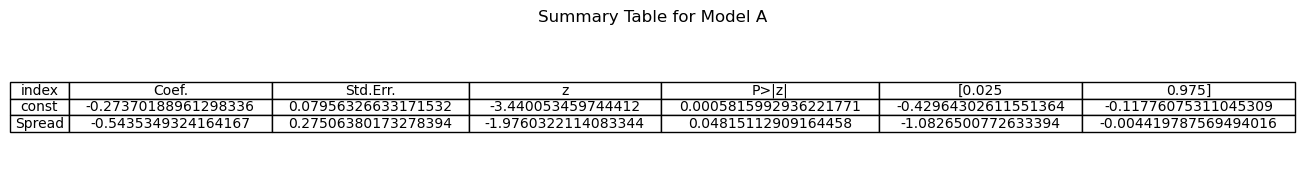

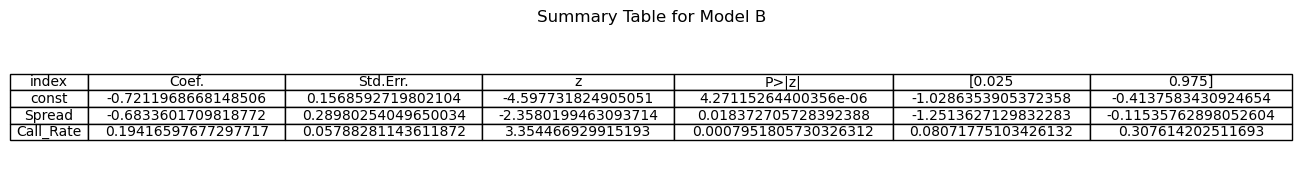

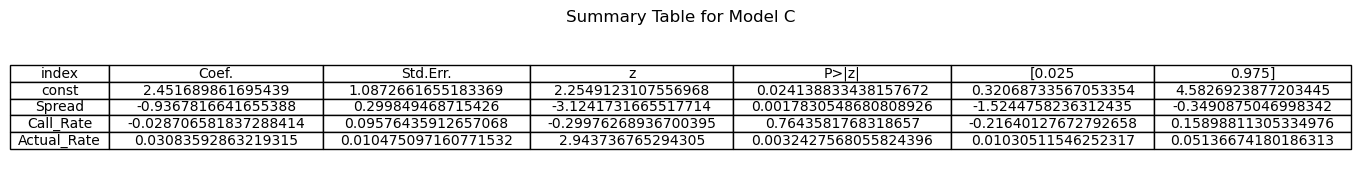

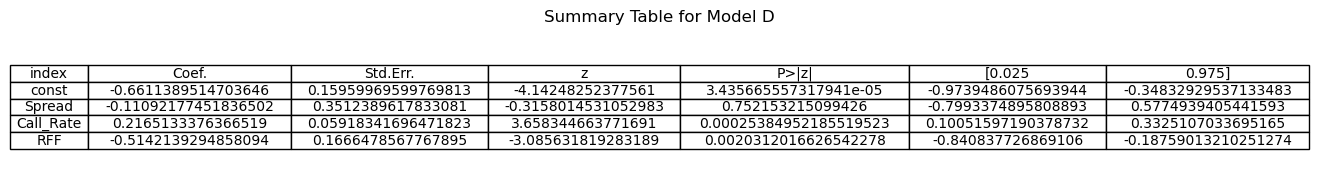

In [10]:
# 회귀 결과 요약 출력 및 시각화 함수 정의
def plot_summary_table(results, model_name):
    summary_table = results.summary2().tables[1]
    summary_table = summary_table.reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 2))  # 표 크기 설정
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=summary_table.values, colLabels=summary_table.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(summary_table.columns))))
    plt.title(f'Summary Table for {model_name}')
    plt.show()

# 모델 A부터 D까지 결과 시각화
plot_summary_table(probit_results_A, "Model A")
plot_summary_table(probit_results_B, "Model B")
plot_summary_table(probit_results_C, "Model C")
plot_summary_table(probit_results_D, "Model D")

### 시각화

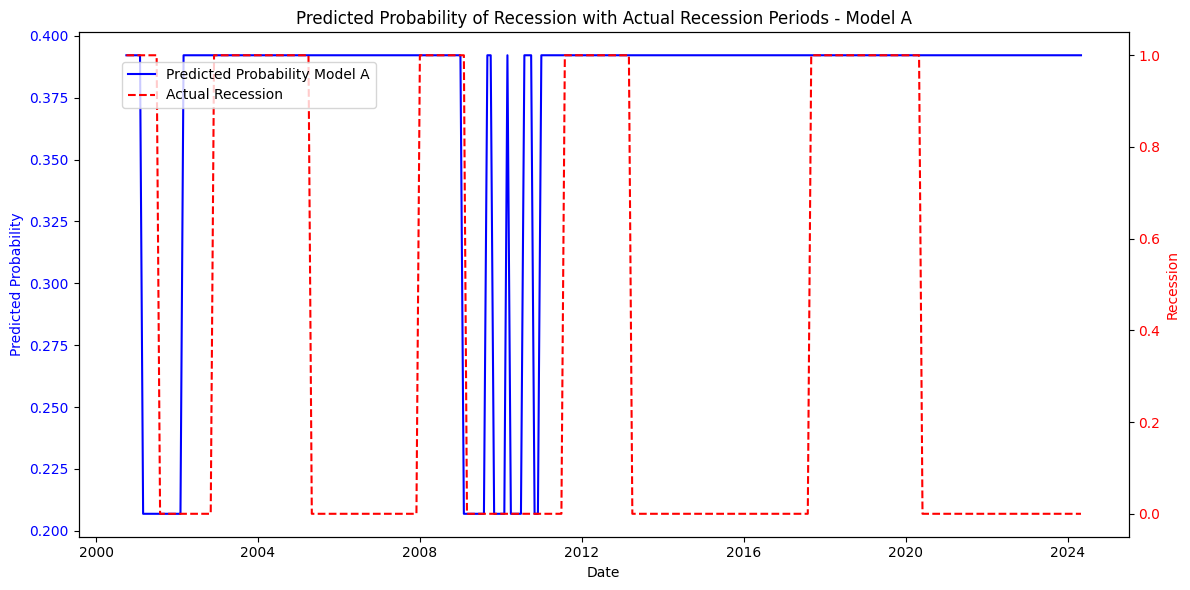

In [106]:
# 모델 A
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data.index, data['Predicted_Probability_A'], label='Predicted Probability Model A', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Probability', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
ax2.set_ylabel('Recession', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Predicted Probability of Recession with Actual Recession Periods - Model A')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

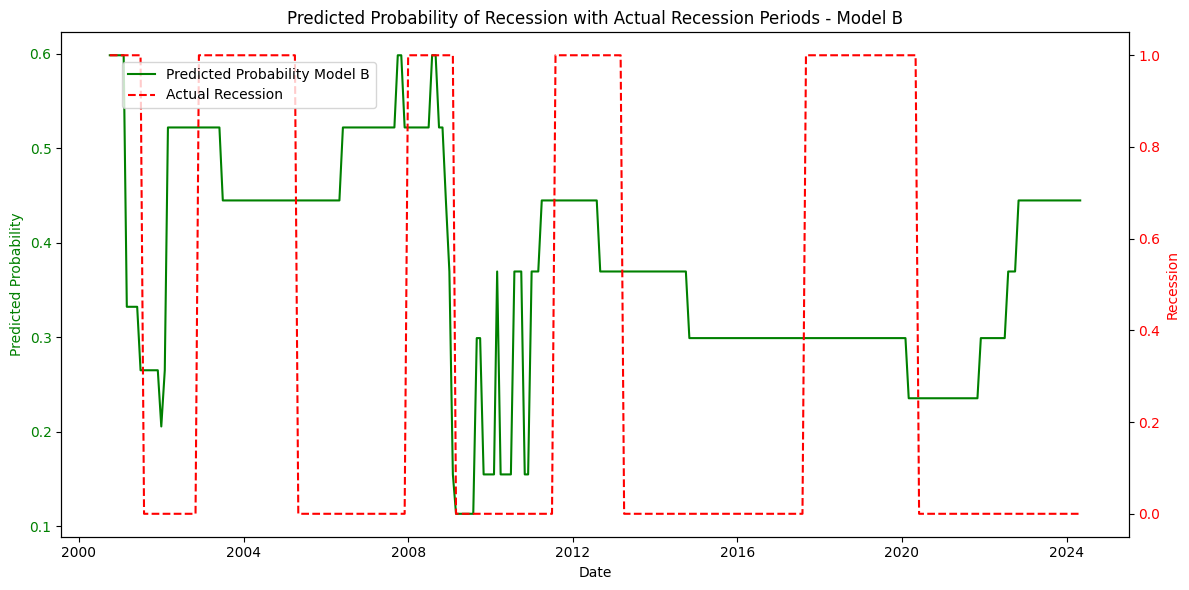

In [107]:
# 모델 B
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data.index, data['Predicted_Probability_B'], label='Predicted Probability Model B', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Probability', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
ax2.set_ylabel('Recession', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Predicted Probability of Recession with Actual Recession Periods - Model B')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

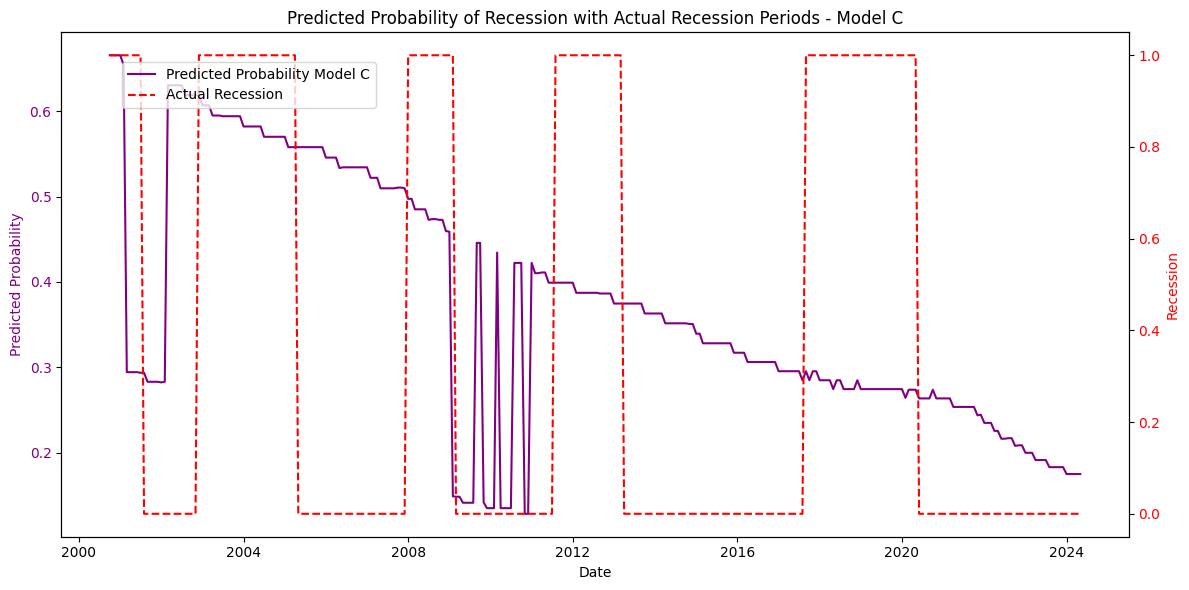

In [108]:
# 모델 C
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data.index, data['Predicted_Probability_C'], label='Predicted Probability Model C', color='purple')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Probability', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

ax2 = ax1.twinx()
ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
ax2.set_ylabel('Recession', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Predicted Probability of Recession with Actual Recession Periods - Model C')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

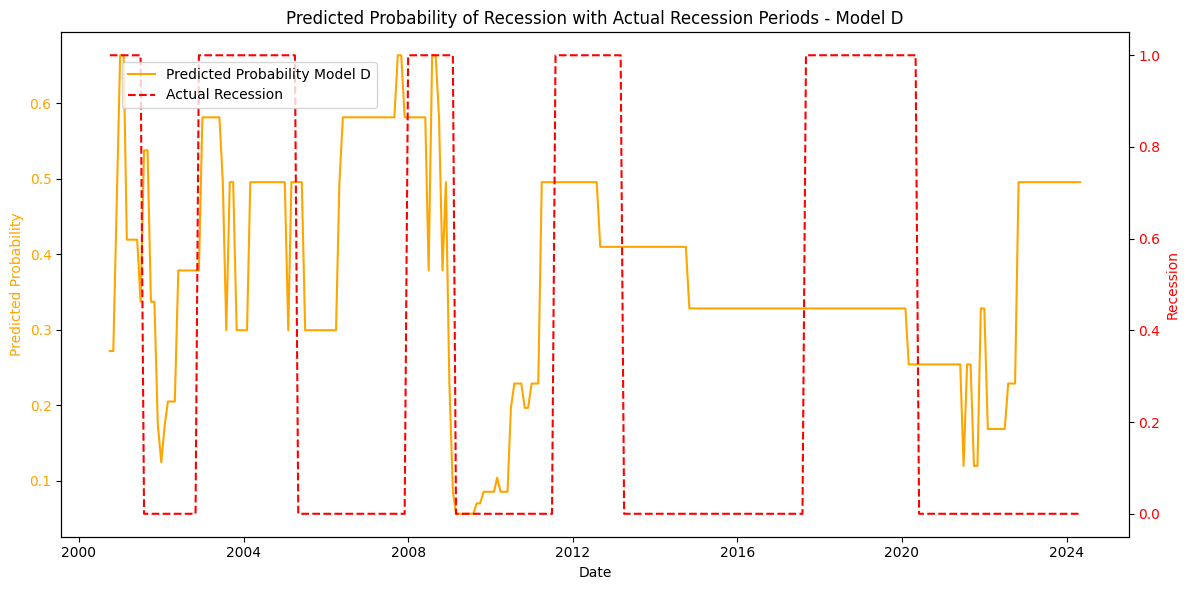

In [109]:
# 모델 D
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data.index, data['Predicted_Probability_D'], label='Predicted Probability Model D', color='orange')
ax1.set_xlabel('Date')
ax1.set_ylabel('Predicted Probability', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
ax2.set_ylabel('Recession', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Predicted Probability of Recession with Actual Recession Periods - Model D')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

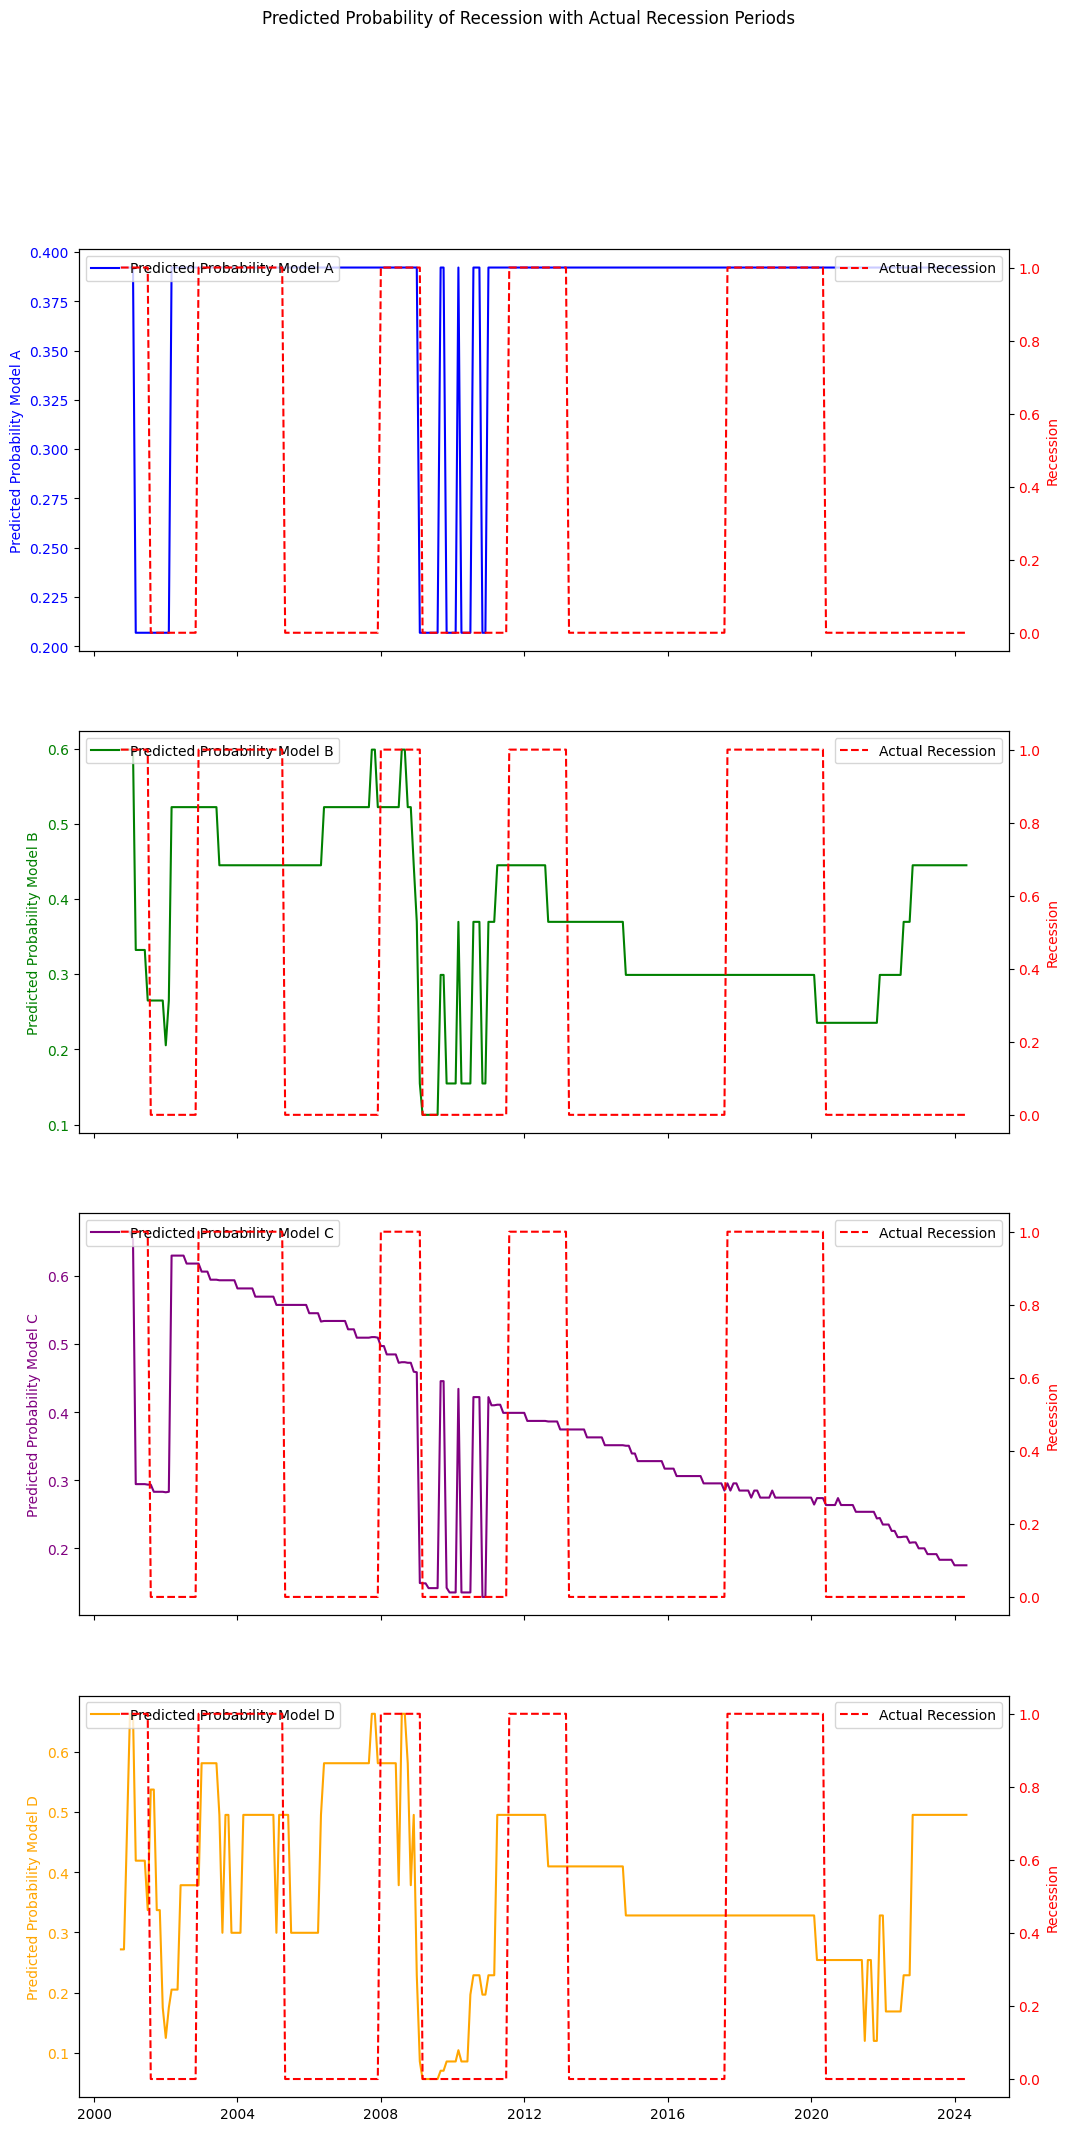

In [110]:
fig, axs = plt.subplots(4, 1, figsize=(12, 24), sharex=True)

models = ['A', 'B', 'C', 'D']
colors = ['blue', 'green', 'purple', 'orange']

for i, model in enumerate(models):
    ax1 = axs[i]
    ax1.plot(data.index, data[f'Predicted_Probability_{model}'], label=f'Predicted Probability Model {model}', color=colors[i])
    ax1.set_ylabel(f'Predicted Probability Model {model}', color=colors[i])
    ax1.tick_params(axis='y', labelcolor=colors[i])
    
    # 두 번째 Y축: 실제 경기침체
    ax2 = ax1.twinx()
    ax2.plot(data.index, data['Recession'], label='Actual Recession', color='red', linestyle='--')
    ax2.set_ylabel('Recession', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# 제목 및 범례 추가
plt.suptitle('Predicted Probability of Recession with Actual Recession Periods')
plt.xlabel('Date')
plt.show()

### 성능 평가

In [111]:
# 엑셀 파일 불러오기
Kyield_data = pd.read_excel('K3Y10Y.xlsx', header=None)
Krecession_data = pd.read_excel('recession_dummy.xlsx', header=None)
Call_rate = pd.read_excel('CallRate.xlsx', header=None)
Core_cpi = pd.read_excel('KcoreCPI.xlsx', header=None)

# 첫 번째 행에 제목 추가
Kyield_data.columns = ['Date', '3Y', '10Y']
Krecession_data.columns = ['Date', 'Recession']
Call_rate.columns = ['Date', 'Call_Rate']
Core_cpi.columns = ['Date', 'Core_CPI']

# 날짜를 인덱스로 설정
Kyield_data['Date'] = pd.to_datetime(Kyield_data['Date'], errors='coerce')
Kyield_data.set_index('Date', inplace=True)

Call_rate['Date'] = pd.to_datetime(Call_rate['Date'], errors='coerce')
Call_rate.set_index('Date', inplace=True)

Core_cpi['Date'] = pd.to_datetime(Core_cpi['Date'], errors='coerce')
Core_cpi.set_index('Date', inplace=True)

Krecession_data['Date'] = pd.to_datetime(Krecession_data['Date'], errors='coerce')
Krecession_data.set_index('Date', inplace=True)

# 데이터 병합
data = Kyield_data.join(Krecession_data, how='left').join(Call_rate, how='left').join(Core_cpi, how='left')
data = data.loc['2000-10-01':]

# 결측치 처리 (전방 채우기) - 한국 데이터는 결측치 없음
data['Recession'] = data['Recession'].fillna(method='ffill').fillna(0)
data['Call_Rate'] = data['Call_Rate'].fillna(method='ffill').fillna(0)
data['Core_CPI'] = data['Core_CPI'].fillna(method='ffill').fillna(0)
data = data.dropna()

# RFF 계산을 위한 추가 데이터 불러오기
Kyield_235_data = pd.read_excel('K2Y3Y5Y.xlsx', header=None)
Kyield_235_data.columns = ['Date','3Y','5Y']
Kyield_235_data['Date'] = pd.to_datetime(Kyield_235_data['Date'], errors='coerce')
Kyield_235_data.set_index('Date', inplace=True)

# 데이터 합치기
Krff_data = pd.concat([Kyield_235_data['3Y'], Kyield_235_data['5Y'], data['10Y'],data['Call_Rate']], axis=1)
Krff_data.columns = ['3yr', '5yr', '10yr', 'CR']
Krff_data.dropna(inplace=True)

# 초과 수익률 계산
Krff_data['Excess_3yr'] = Krff_data['3yr'] - Krff_data['CR']
Krff_data['Excess_5yr'] = Krff_data['5yr'] - Krff_data['CR']

# Return Forecasting Factor 계산 (2년에서 5년 만기 채권의 초과 수익률 평균)
Krff_data['RFF'] = Krff_data[['Excess_3yr', 'Excess_5yr']].mean(axis=1)

# RFF를 원래 데이터에 병합
data = data.join(Krff_data['RFF'], how='left')

# RFF를 원래 데이터에 병합
# Overlap 문제 해결
data = data.join(Krff_data['RFF'], how='left', rsuffix='_rff')

# Yield spread 계산 (10년 - 3년)
data['Spread'] = data['10Y'] - data['3Y']

# Probit 모델 적용
y = data['Recession']

In [113]:
data['3Y'] = data['3Y'].astype(int)
data['10Y'] = data['10Y'].astype(int)
data['Recession'] = data['Recession'].astype(int)
data['Call_Rate'] = data['Call_Rate'].astype(int)
data['Core_CPI'] = data['Core_CPI'].astype(int)
data['RFF'] = data['RFF'].astype(int)
data['Spread'] = data['Spread'].astype(int)
y = data['Recession']

In [114]:
# 모델 A: SPREAD_3m_10y
X_A = data[['Spread']]
X_A = sm.add_constant(X_A)

probit_model_A = sm.Probit(y, X_A)
probit_results_A = probit_model_A.fit()
data['Predicted_Probability_A'] = probit_results_A.predict(X_A)
print(probit_results_A.summary())

# 모델 B: SPREAD, FF
X_B = data[['Spread', 'Call_Rate']]
X_B = sm.add_constant(X_B)

probit_model_B = sm.Probit(y, X_B)
probit_results_B = probit_model_B.fit()
data['Predicted_Probability_B'] = probit_results_B.predict(X_B)
print(probit_results_B.summary())

# 모델 C: SPREAD, CallRate, Actual_Rate
data['Actual_Rate'] = data['Call_Rate'] - data['Core_CPI']
X_C = data[['Spread', 'Call_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)

probit_model_C = sm.Probit(y, X_C)
probit_results_C = probit_model_C.fit()
data['Predicted_Probability_C'] = probit_results_C.predict(X_C)
print(probit_results_C.summary())

# 모델 D: SPREAD, FF, RFF
X_D = data[['Spread', 'Call_Rate', 'RFF']]
X_D = sm.add_constant(X_D)

probit_model_D = sm.Probit(y, X_D)
probit_results_D = probit_model_D.fit()
data['Predicted_Probability_D'] = probit_results_D.predict(X_D)
print(probit_results_D.summary())

Optimization terminated successfully.
         Current function value: 0.653377
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  284
Model:                         Probit   Df Residuals:                      282
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                 0.01102
Time:                        15:55:21   Log-Likelihood:                -185.56
converged:                       True   LL-Null:                       -187.63
Covariance Type:            nonrobust   LLR p-value:                   0.04199
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2737      0.080     -3.440      0.001      -0.430      -0.118
Spread        -0.5435      0.

In [115]:
# RMSE 및 RMSLE 계산 및 출력
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = data[f'Predicted_Probability_{model}']
    y_true = data['Recession']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # log transformation을 위해 1을 더함
    print(f'Model {model} - RMSE: {rmse}, RMSLE: {rmsle}')

Model A - RMSE: 0.48040085380338254, RMSLE: 0.19576464800112564
Model B - RMSE: 0.47169908732139987, RMSLE: 0.19210041702488226
Model C - RMSE: 0.4639955970639599, RMSLE: 0.1888649137549755
Model D - RMSE: 0.46491954711312633, RMSLE: 0.18915050809665448


### 내표본과 외표본의 구분

In [118]:
# 내표본 데이터 (~20010Q4)
in_sample_data = data.loc[:'2010-12-31']

# 외표본 데이터 (2000Q3~2023Q1)
out_of_sample_data = data.loc['1980-10-01':]

# 모델 A: SPREAD_3m_10y
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
out_of_sample_data['Predicted_Probability_A'] = probit_model_A.predict(sm.add_constant(out_of_sample_data[['Spread']]))
print(probit_model_A.summary())

# 모델 B: SPREAD, FF
X_B = in_sample_data[['Spread', 'Call_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
out_of_sample_data['Predicted_Probability_B'] = probit_model_B.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate']]))
print(probit_model_B.summary())

# 모델 C: SPREAD, FF, Actual_Rate
in_sample_data['Actual_Rate'] = in_sample_data['Call_Rate'] - in_sample_data['Core_CPI']
out_of_sample_data['Actual_Rate'] = out_of_sample_data['Call_Rate'] - out_of_sample_data['Core_CPI']
X_C = in_sample_data[['Spread', 'Call_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
out_of_sample_data['Predicted_Probability_C'] = probit_model_C.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate', 'Actual_Rate']]))
print(probit_model_C.summary())

# 모델 D: SPREAD, FF, RFF
X_D = in_sample_data[['Spread', 'Call_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
out_of_sample_data['Predicted_Probability_D'] = probit_model_D.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate', 'RFF']]))
print(probit_model_D.summary())

Optimization terminated successfully.
         Current function value: 0.649923
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:              Recession   No. Observations:                  123
Model:                         Probit   Df Residuals:                      121
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                 0.04922
Time:                        15:57:38   Log-Likelihood:                -79.940
converged:                       True   LL-Null:                       -84.079
Covariance Type:            nonrobust   LLR p-value:                  0.004017
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.521e-17      0.129   5.04e-16      1.000      -0.253       0.253
Spread        -0.8172      0.

### **외표본 (out of sample)**
    - RSME, RSMLE

In [119]:
# RMSE 및 RMSLE 계산 및 출력 (외표본 데이터)
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']  # 모델의 예측 확률
    y_true = out_of_sample_data['Recession']  # 실제 경기침체 여부
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE 계산
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # RMSLE 계산 (log transformation을 위해 1을 더함)
    print(f'Model {model} - RMSE: {rmse}, RMSLE: {rmsle}')

Model A - RMSE: 0.4911492009966329, RMSLE: 0.20409973604396484
Model B - RMSE: 0.4782549614015145, RMSLE: 0.19347898827640475
Model C - RMSE: 0.49697041513951234, RMSLE: 0.19988797153724536
Model D - RMSE: 0.4658253041455986, RMSLE: 0.19048444323335473


Model A - RMSE: 0.4911, RMSLE: 0.2041
Model B - RMSE: 0.4783, RMSLE: 0.1935
Model C - RMSE: 0.4970, RMSLE: 0.1999
Model D - RMSE: 0.4658, RMSLE: 0.1905


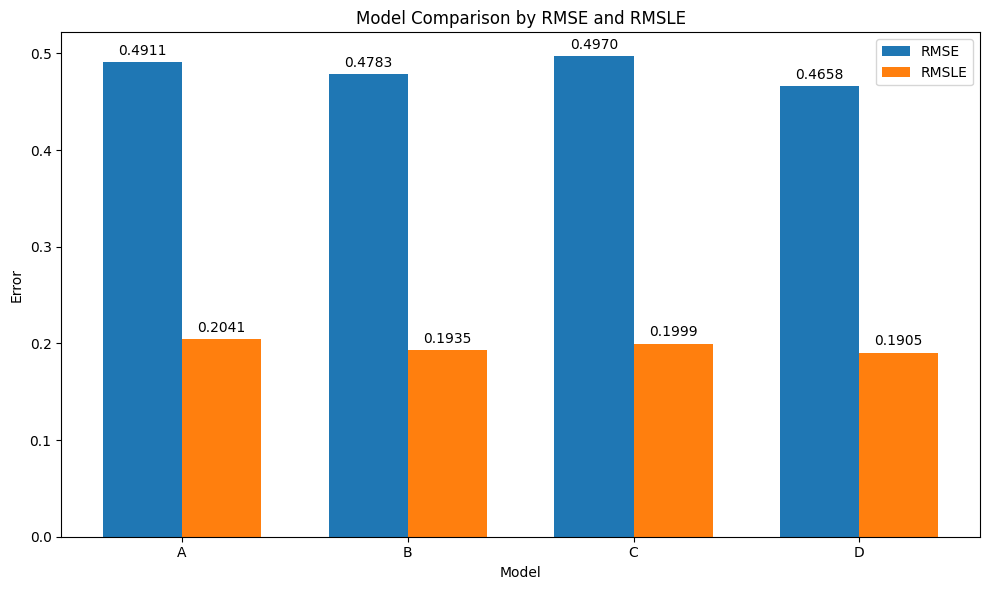

In [120]:
# RMSE 및 RMSLE 계산 및 저장
models = ['A', 'B', 'C', 'D']
rmse_values = []
rmsle_values = []

for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']  # 모델의 예측 확률
    y_true = out_of_sample_data['Recession']  # 실제 경기침체 여부
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE 계산
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # RMSLE 계산 (log transformation을 위해 1을 더함)
    rmse_values.append(rmse)
    rmsle_values.append(rmsle)
    print(f'Model {model} - RMSE: {rmse:.4f}, RMSLE: {rmsle:.4f}')

# 성능 비교 그래프 그리기
x = np.arange(len(models))  # 모델 인덱스
width = 0.35  # 막대 너비

fig, ax = plt.subplots(figsize=(10, 6))

# RMSE 막대
rmse_bars = ax.bar(x - width/2, rmse_values, width, label='RMSE')
# RMSLE 막대
rmsle_bars = ax.bar(x + width/2, rmsle_values, width, label='RMSLE')

# 라벨 추가
ax.set_xlabel('Model')
ax.set_ylabel('Error')
ax.set_title('Model Comparison by RMSE and RMSLE')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# 막대에 값 표시
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rmse_bars)
autolabel(rmsle_bars)

fig.tight_layout()

plt.show()

### **내표본(in sample)**
    - 내표본 데이터 성능 평가 BIC, R-squared

In [121]:
# 내표본 데이터 (~2010Q4)
in_sample_data = data.loc[:'2010-12-31']

# BIC 및 McFadden's R-제곱 계산 및 출력
models = ['A', 'B', 'C', 'D']
bic_values = []
r_squared_values = []

# 모델 A
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
bic_values.append(probit_model_A.bic)
r_squared_values.append(probit_model_A.prsquared)
print(f'Model A - BIC: {probit_model_A.bic}, McFadden\'s R-squared: {probit_model_A.prsquared}')

# 모델 B
X_B = in_sample_data[['Spread', 'Call_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
bic_values.append(probit_model_B.bic)
r_squared_values.append(probit_model_B.prsquared)
print(f'Model B - BIC: {probit_model_B.bic}, McFadden\'s R-squared: {probit_model_B.prsquared}')

# 모델 C
in_sample_data['Actual_Rate'] = in_sample_data['Call_Rate'] - in_sample_data['Core_CPI']
X_C = in_sample_data[['Spread', 'Call_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
bic_values.append(probit_model_C.bic)
r_squared_values.append(probit_model_C.prsquared)
print(f'Model C - BIC: {probit_model_C.bic}, McFadden\'s R-squared: {probit_model_C.prsquared}')

# 모델 D
X_D = in_sample_data[['Spread', 'Call_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
bic_values.append(probit_model_D.bic)
r_squared_values.append(probit_model_D.prsquared)
print(f'Model D - BIC: {probit_model_D.bic}, McFadden\'s R-squared: {probit_model_D.prsquared}')

Optimization terminated successfully.
         Current function value: 0.649923
         Iterations 5
Model A - BIC: 169.50534923175252, McFadden's R-squared: 0.049216449557712205
Optimization terminated successfully.
         Current function value: 0.619670
         Iterations 5
Model B - BIC: 166.87549572094488, McFadden's R-squared: 0.09347291559810456
Optimization terminated successfully.
         Current function value: 0.601880
         Iterations 6
Model C - BIC: 167.31124907695948, McFadden's R-squared: 0.1194987667673646
Optimization terminated successfully.
         Current function value: 0.599807
         Iterations 6
Model D - BIC: 166.80116906910777, McFadden's R-squared: 0.12253212119948331


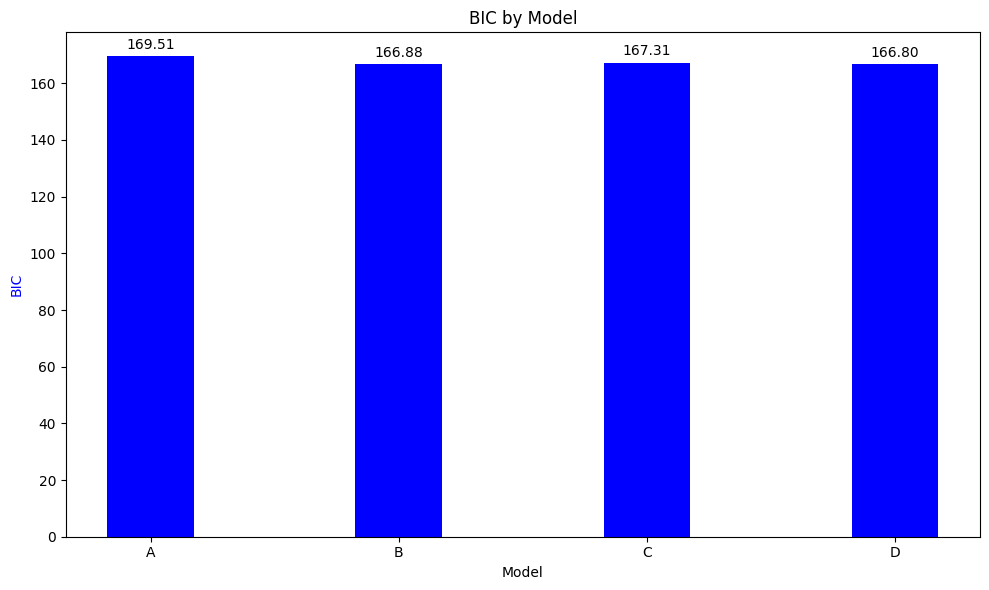

In [122]:
models = ['A', 'B', 'C', 'D']

# BIC 값 및 R-제곱 값
bic_values = [probit_model_A.bic, probit_model_B.bic, probit_model_C.bic, probit_model_D.bic]

# BIC 그래프
fig, ax1 = plt.subplots(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

bic_bars = ax1.bar(x, bic_values, width, label='BIC', color='blue')
ax1.set_xlabel('Model')
ax1.set_ylabel('BIC', color='blue')
ax1.set_title('BIC by Model')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# 막대에 값 표시
for bar in bic_bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()
plt.show()

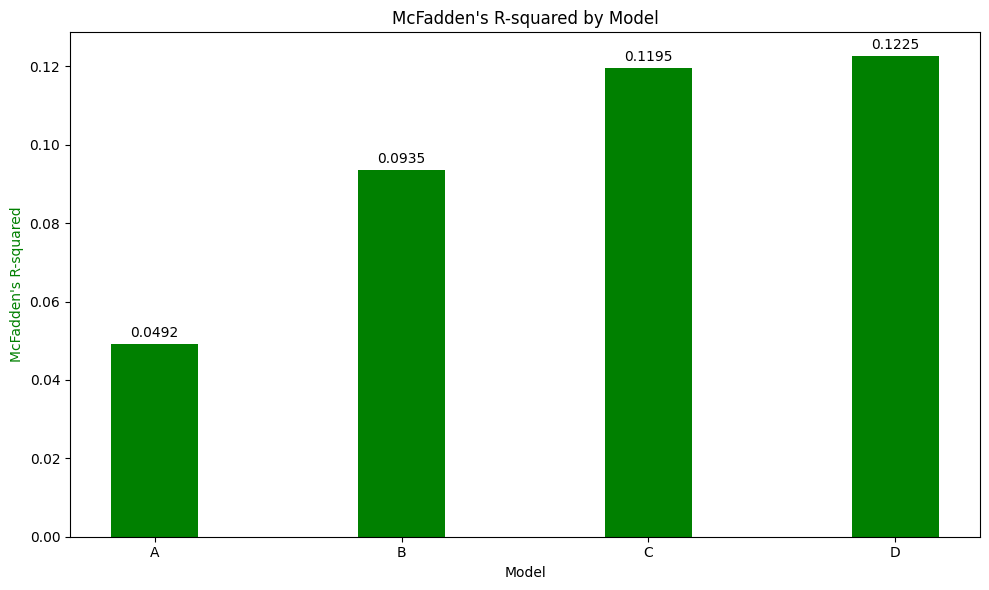

In [123]:
# R-제곱 그래프
r_squared_values = [probit_model_A.prsquared, probit_model_B.prsquared, probit_model_C.prsquared, probit_model_D.prsquared]

fig, ax2 = plt.subplots(figsize=(10, 6))
r_squared_bars = ax2.bar(x, r_squared_values, width, label="McFadden's R-squared", color='green')
ax2.set_xlabel('Model')
ax2.set_ylabel("McFadden's R-squared", color='green')
ax2.set_title("McFadden's R-squared by Model")
ax2.set_xticks(x)
ax2.set_xticklabels(models)

for bar in r_squared_bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()
plt.show()

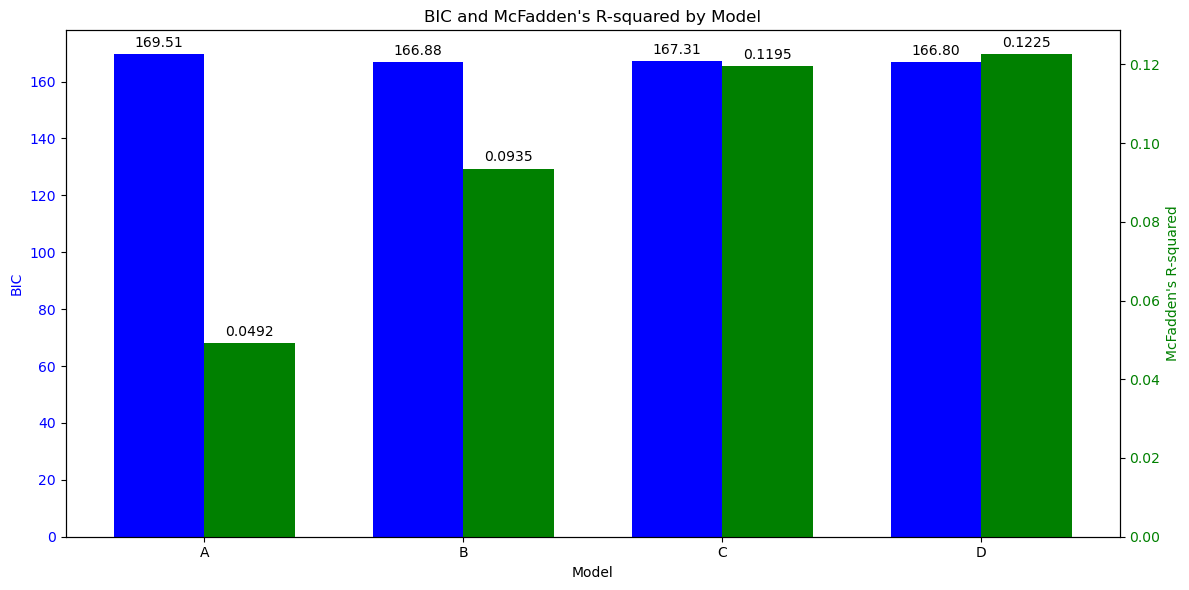

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 이름
models = ['A', 'B', 'C', 'D']

# BIC 값 및 R-제곱 값
bic_values = [169.51, 166.88, 167.31, 166.80]
r_squared_values = [0.0492, 0.0935, 0.1195, 0.1225]

# 막대 너비 설정
width = 0.35

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

# x축 위치 설정
x = np.arange(len(models))

# BIC 막대 그래프
bic_bars = ax1.bar(x - width/2, bic_values, width, label='BIC', color='blue')
ax1.set_xlabel('Model')
ax1.set_ylabel('BIC', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('BIC and McFadden\'s R-squared by Model')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# 막대 위에 값 표시
for bar in bic_bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# McFadden's R-squared 막대 그래프
ax2 = ax1.twinx()
r_squared_bars = ax2.bar(x + width/2, r_squared_values, width, label="McFadden's R-squared", color='green')
ax2.set_ylabel("McFadden's R-squared", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 막대 위에 값 표시
for bar in r_squared_bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()
plt.show()

## **성능 정리**

Optimization terminated successfully.
         Current function value: 0.649923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599807
         Iterations 6
  Model      RMSE     RMSLE         BIC  R-squared
0     A  0.491149  0.204100  169.505349   0.049216
1     B  0.478255  0.193479  166.875496   0.093473
2     C  0.496970  0.199888  167.311249   0.119499
3     D  0.465825  0.190484  166.801169   0.122532


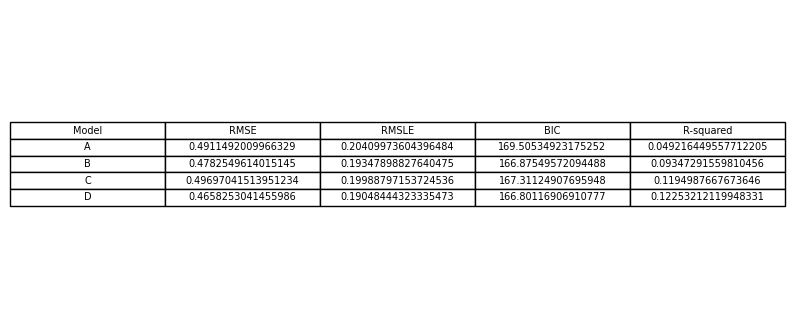

In [125]:
# 내표본 데이터 (~ 2010Q4)
in_sample_data = data.loc[:'2010-12-31']

# 외표본 데이터 (2000Q3~)
out_of_sample_data = data.loc['2000-10-01':]

# 딕셔너리
results = {
    'Model': ['A', 'B', 'C', 'D'],
    'RMSE': [],
    'RMSLE': [],
    'BIC': [],
    'R-squared': []
}

# 모델 A
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
out_of_sample_data['Predicted_Probability_A'] = probit_model_A.predict(sm.add_constant(out_of_sample_data[['Spread']]))
results['BIC'].append(probit_model_A.bic)
results['R-squared'].append(probit_model_A.prsquared)

# 모델 B
X_B = in_sample_data[['Spread', 'Call_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
out_of_sample_data['Predicted_Probability_B'] = probit_model_B.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate']]))
results['BIC'].append(probit_model_B.bic)
results['R-squared'].append(probit_model_B.prsquared)

# 모델 C: SPREAD, FF, Actual_Rate
in_sample_data['Actual_Rate'] = in_sample_data['Call_Rate'] - in_sample_data['Core_CPI']
out_of_sample_data['Actual_Rate'] = out_of_sample_data['Call_Rate'] - out_of_sample_data['Core_CPI']
X_C = in_sample_data[['Spread', 'Call_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
out_of_sample_data['Predicted_Probability_C'] = probit_model_C.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate', 'Actual_Rate']]))
results['BIC'].append(probit_model_C.bic)
results['R-squared'].append(probit_model_C.prsquared)

# 모델 D: SPREAD, FF, RFF
X_D = in_sample_data[['Spread', 'Call_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
out_of_sample_data['Predicted_Probability_D'] = probit_model_D.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate', 'RFF']]))
results['BIC'].append(probit_model_D.bic)
results['R-squared'].append(probit_model_D.prsquared)

# RMSE 및 RMSLE 계산
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']
    y_true = out_of_sample_data['Recession']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # log transformation을 위해 1을 더합니다
    results['RMSE'].append(rmse)
    results['RMSLE'].append(rmsle)

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 결과 출력
print(results_df)

fig, ax = plt.subplots(figsize=(10, 4)) 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc = 'center', loc='center')

plt.show()

Optimization terminated successfully.
         Current function value: 0.649923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599807
         Iterations 6
  Model      RMSE     RMSLE         BIC  R-squared
0     A  0.491149  0.204100  169.505349   0.049216
1     B  0.478255  0.193479  166.875496   0.093473
2     C  0.496970  0.199888  167.311249   0.119499
3     D  0.465825  0.190484  166.801169   0.122532


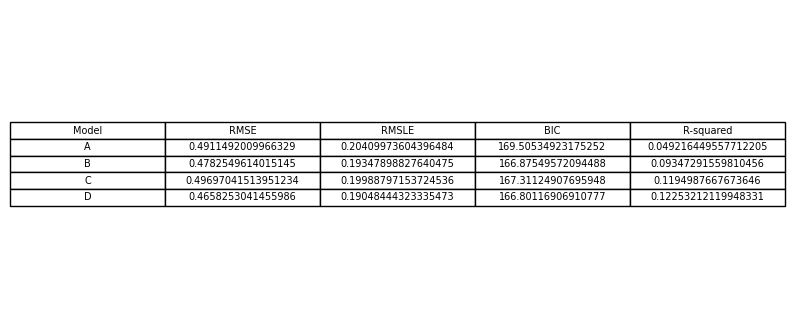

In [126]:
# 내표본 데이터 (~ 2010Q4)
in_sample_data = data.loc[:'2010-12-31']

# 외표본 데이터 (2000Q3~)
out_of_sample_data = data.loc['2000-10-01':]

# 딕셔너리
results = {
    'Model': ['A', 'B', 'C', 'D'],
    'RMSE': [],
    'RMSLE': [],
    'BIC': [],
    'R-squared': []
}

# 모델 A
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
out_of_sample_data['Predicted_Probability_A'] = probit_model_A.predict(sm.add_constant(out_of_sample_data[['Spread']]))
results['BIC'].append(probit_model_A.bic)
results['R-squared'].append(probit_model_A.prsquared)

# 모델 B
X_B = in_sample_data[['Spread', 'Call_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
out_of_sample_data['Predicted_Probability_B'] = probit_model_B.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate']]))
results['BIC'].append(probit_model_B.bic)
results['R-squared'].append(probit_model_B.prsquared)

# 모델 C: SPREAD, FF, Actual_Rate
in_sample_data['Actual_Rate'] = in_sample_data['Call_Rate'] - in_sample_data['Core_CPI']
out_of_sample_data['Actual_Rate'] = out_of_sample_data['Call_Rate'] - out_of_sample_data['Core_CPI']
X_C = in_sample_data[['Spread', 'Call_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
out_of_sample_data['Predicted_Probability_C'] = probit_model_C.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate', 'Actual_Rate']]))
results['BIC'].append(probit_model_C.bic)
results['R-squared'].append(probit_model_C.prsquared)

# 모델 D: SPREAD, FF, RFF
X_D = in_sample_data[['Spread', 'Call_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
out_of_sample_data['Predicted_Probability_D'] = probit_model_D.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate', 'RFF']]))
results['BIC'].append(probit_model_D.bic)
results['R-squared'].append(probit_model_D.prsquared)

# RMSE 및 RMSLE 계산
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']
    y_true = out_of_sample_data['Recession']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # log transformation을 위해 1을 더합니다
    results['RMSE'].append(rmse)
    results['RMSLE'].append(rmsle)

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 가장 성능이 좋은 값을 색으로 칠하기
def highlight_best(s):
    is_best = s == s.min() if s.name in ['RMSE', 'RMSLE', 'BIC'] else s == s.max()
    return ['background-color: yellow' if v else '' for v in is_best]

results_df_styled = results_df.style.apply(highlight_best)

# 결과 출력
print(results_df)

# 결과를 표로 표시
fig, ax = plt.subplots(figsize=(10, 4)) 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')

plt.show()

In [127]:
results_df.columns

Index(['Model', 'RMSE', 'RMSLE', 'BIC', 'R-squared'], dtype='object')

In [128]:
results_df_styled

,Model,RMSE,RMSLE,BIC,R-squared
0,A,0.491149,0.204100,169.505349,0.049216
1,B,0.478255,0.193479,166.875496,0.093473
2,C,0.496970,0.199888,167.311249,0.119499
3,D,0.465825,0.190484,166.801169,0.122532


Optimization terminated successfully.
         Current function value: 0.649923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599807
         Iterations 6
  Model      RMSE     RMSLE         BIC  R-squared
0     A  0.491149  0.204100  169.505349   0.049216
1     B  0.478255  0.193479  166.875496   0.093473
2     C  0.496970  0.199888  167.311249   0.119499
3     D  0.465825  0.190484  166.801169   0.122532


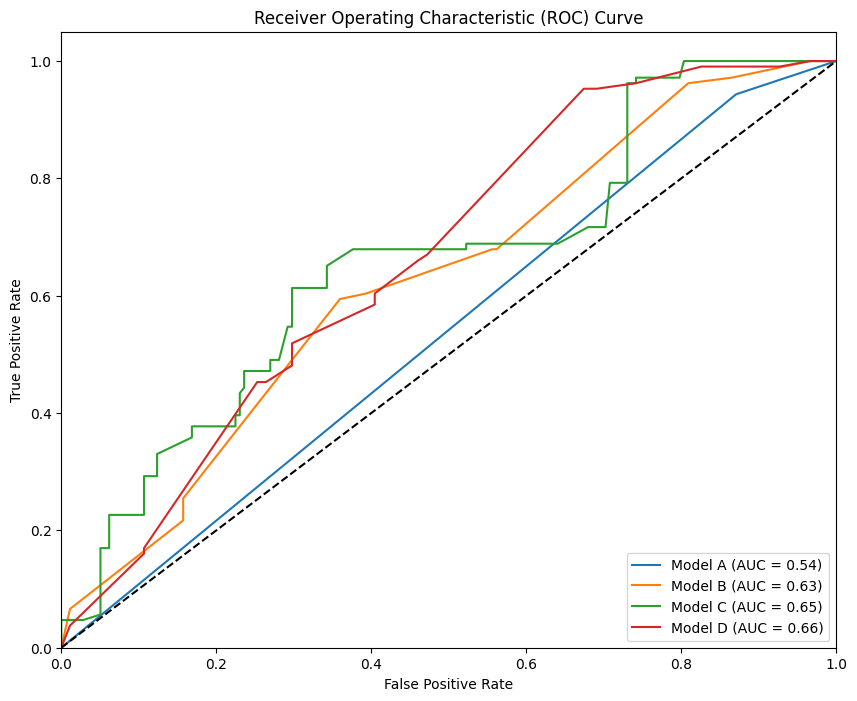

In [134]:
# 딕셔너리
results = {
    'Model': ['A', 'B', 'C', 'D'],
    'RMSE': [],
    'RMSLE': [],
    'BIC': [],
    'R-squared': []
}

# 모델 A
X_A = in_sample_data[['Spread']]
X_A = sm.add_constant(X_A)
probit_model_A = sm.Probit(in_sample_data['Recession'], X_A).fit()
out_of_sample_data['Predicted_Probability_A'] = probit_model_A.predict(sm.add_constant(out_of_sample_data[['Spread']]))
results['BIC'].append(probit_model_A.bic)
results['R-squared'].append(probit_model_A.prsquared)

# 모델 B
X_B = in_sample_data[['Spread', 'Call_Rate']]
X_B = sm.add_constant(X_B)
probit_model_B = sm.Probit(in_sample_data['Recession'], X_B).fit()
out_of_sample_data['Predicted_Probability_B'] = probit_model_B.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate']]))
results['BIC'].append(probit_model_B.bic)
results['R-squared'].append(probit_model_B.prsquared)

# 모델 C: SPREAD, FF, Actual_Rate
in_sample_data['Actual_Rate'] = in_sample_data['Call_Rate'] - in_sample_data['Core_CPI']
out_of_sample_data['Actual_Rate'] = out_of_sample_data['Call_Rate'] - out_of_sample_data['Core_CPI']
X_C = in_sample_data[['Spread', 'Call_Rate', 'Actual_Rate']]
X_C = sm.add_constant(X_C)
probit_model_C = sm.Probit(in_sample_data['Recession'], X_C).fit()
out_of_sample_data['Predicted_Probability_C'] = probit_model_C.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate', 'Actual_Rate']]))
results['BIC'].append(probit_model_C.bic)
results['R-squared'].append(probit_model_C.prsquared)

# 모델 D: SPREAD, FF, RFF
X_D = in_sample_data[['Spread', 'Call_Rate', 'RFF']]
X_D = sm.add_constant(X_D)
probit_model_D = sm.Probit(in_sample_data['Recession'], X_D).fit()
out_of_sample_data['Predicted_Probability_D'] = probit_model_D.predict(sm.add_constant(out_of_sample_data[['Spread', 'Call_Rate', 'RFF']]))
results['BIC'].append(probit_model_D.bic)
results['R-squared'].append(probit_model_D.prsquared)

# RMSE 및 RMSLE 계산
models = ['A', 'B', 'C', 'D']
for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']
    y_true = out_of_sample_data['Recession']
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true + 1, y_pred + 1))  # log transformation을 위해 1을 더합니다
    results['RMSE'].append(rmse)
    results['RMSLE'].append(rmsle)

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 가장 성능이 좋은 값을 색으로 칠하기
def highlight_best(s):
    is_best = s == s.min() if s.name in ['RMSE', 'RMSLE', 'BIC'] else s == s.max()
    return ['background-color: yellow' if v else '' for v in is_best]

results_df_styled = results_df.style.apply(highlight_best)

# 결과 출력
print(results_df)

# ROC 커브 그리기
plt.figure(figsize=(10, 8))

for model in models:
    y_pred = out_of_sample_data[f'Predicted_Probability_{model}']
    y_true = out_of_sample_data['Recession']
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Model {model} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()